In [60]:
import numpy as np
import sqlite3

from tensordict import TensorDict  
import os
from pathlib import Path

# Setup

In [ ]:
BASE_OUTPUT_DIR = Path("/mnt/d/Workspace/Networks/RL-Project/ns-o-ran-gym/output") # change this to your output directory

TEST_OUTPUT_DIRS = [ 
    BASE_OUTPUT_DIR/"2/eval/conservative" , 
    BASE_OUTPUT_DIR/"-1/eval/dqn-new",
    BASE_OUTPUT_DIR/"-1/eval/dqn-new-rs",
    BASE_OUTPUT_DIR/"-1/eval/ppo-10",
    BASE_OUTPUT_DIR/"-1/eval/ppo-4",
    BASE_OUTPUT_DIR/"-1/eval/ppo-5",
    BASE_OUTPUT_DIR/"-1/eval/ppo-mb-1",
    BASE_OUTPUT_DIR/"-1/eval/ppo-mb-11",
]

metadata = [
    # "always-on",
    "benchmark-dynamic",
    "dqn-1", #base-dqn
    "dqn-2", # reward shaping 0.4,0.4,0.1,0.1
    "ppo-1", # base
    "ppo-2", # reward shaping 0.4,0.4,0.1,0.1
    "ppo-3", # reward shaping 0.75, 0.15, 0.5, 0.05
    "ppo-mb-1", # base-ppo-mb
    "ppo-mb-2", # reward shaping 0.4,0.4,0.1,0.1, deeper
]



colors = [
    'tab:orange', 
    'tab:pink' ,  
    'tab:olive', 
    'tab:green', 
    'tab:purple', 
    'tab:gray',
    "tab:cyan",
    'tab:blue', 
]
markers = [
    'o',
    's', 
    '8',
    '^', 
    'x', 
    '*',
    'D',
    '+', 
]

## Utils

In [62]:
import os
def get_all_directories(basepath):
    directories = []
    for root, dirs, files in os.walk(basepath):
        for dir in dirs:
            directories.append(os.path.join(root, dir))

    directories = sorted(directories, key=os.path.getmtime)
    return directories    
# GET 
def extract_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT timestamp,throughput,en_cons,rlf,on_cost,reward FROM grafana")
    rows = cursor.fetchall()
    conn.close()
    return np.array(rows)

In [63]:
all_sims = [get_all_directories(TEST_OUTPUT_DIR) for TEST_OUTPUT_DIR in TEST_OUTPUT_DIRS]

all_valid_sims = [
    [sim for sim in sims[-16:] if extract_from_db(os.path.join(sim, "database.db")).shape[0]]
    for sims in all_sims
]

In [64]:
len(all_valid_sims)

8

In [65]:
from matplotlib import pyplot as plt

In [66]:
columns = ["throughput", "en_cons", "rlf", "on_cost", "reward"]

## Cumulative Distribution Function (CDF) Plotting

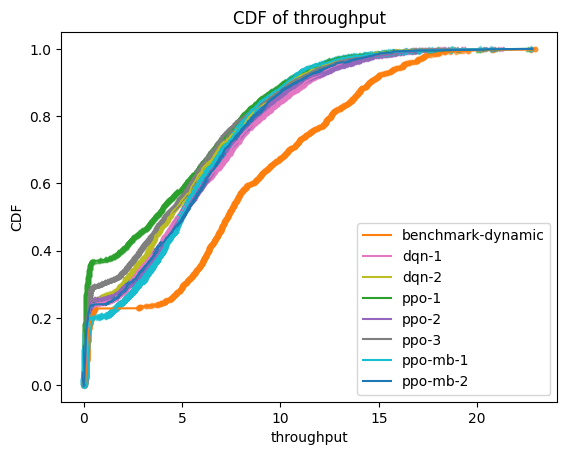

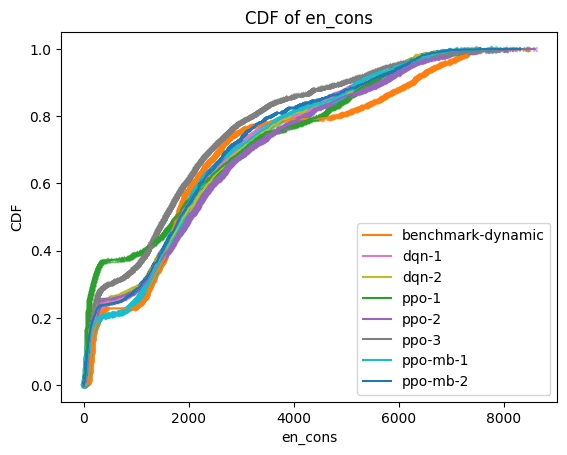

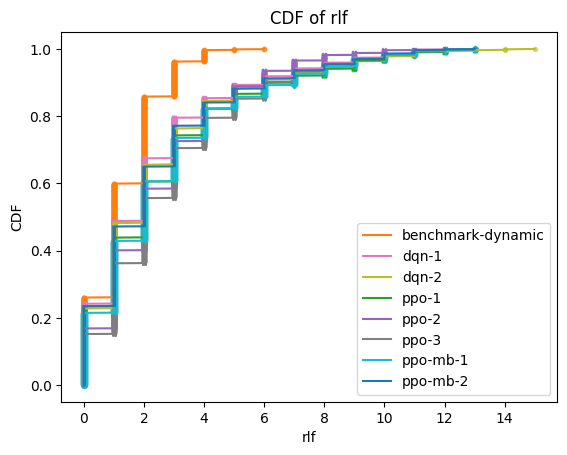

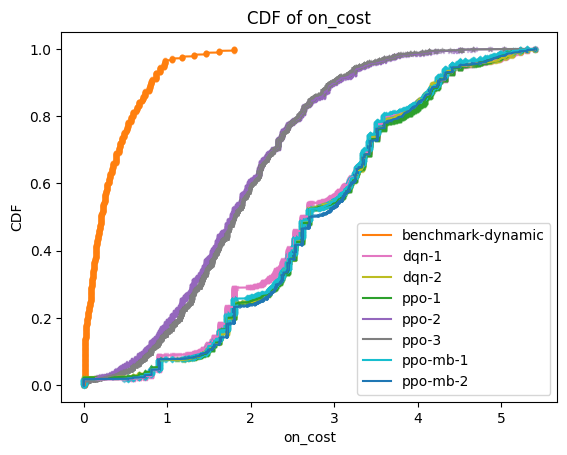

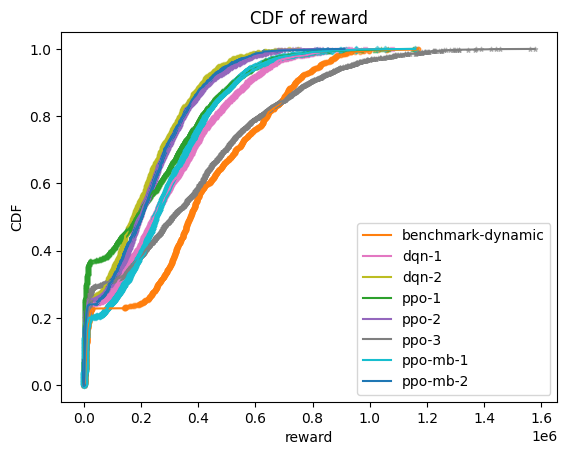

In [67]:
# Create a CDF of all columns, combine in sim in sims as one plot. PLot per colum

for col in columns:
    plt.figure()
    for idx, valid_sims in enumerate(all_valid_sims):
        all_data = []
        for sim in valid_sims:
            data = extract_from_db(os.path.join(sim, "database.db"))[:, columns.index(col) + 1]
            all_data.extend(data)
        all_data = np.array(all_data)
        sorted_data = np.sort(all_data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        plt.plot(sorted_data, cdf, label=metadata[idx], color=colors[idx])
        # Change the line style for each plot
        plt.scatter(sorted_data, cdf, color=colors[idx], marker=markers[idx], s=10, alpha=0.5)
        
    plt.xlabel(col)
    plt.ylabel("CDF")
    plt.title(f"CDF of {col}")
    plt.legend()
    plt.show()

## Scatterplot 

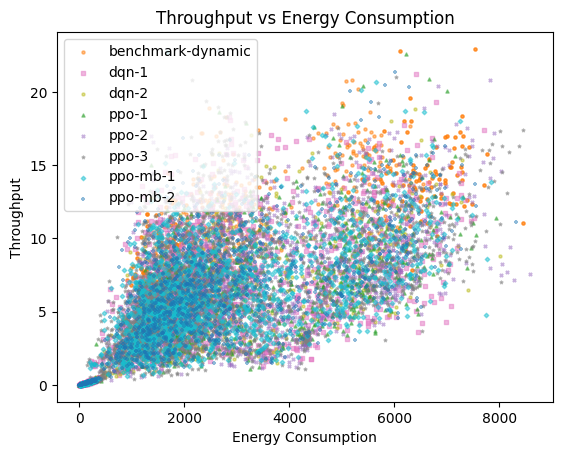

In [68]:
from matplotlib import pyplot as plt

# colors = ['tab:orange', 'tab:pink' ,  'tab:blue', 'tab:purple', 'tab:green', "tab:cyan"]
# markers = ['o','s', '+', 'x', '^', 'D']


plt.figure()
for idx, valid_sims in enumerate(all_valid_sims):
    all_throughput = []
    all_en_cons = []
    for sim in valid_sims:
        data = extract_from_db(os.path.join(sim, "database.db"))
        all_throughput.extend(data[:, 1])
        all_en_cons.extend(data[:, 2])
    plt.scatter(
        all_en_cons, all_throughput,
        color=colors[idx],
        marker=markers[idx],
        label=metadata[idx],
        alpha=0.5,
        s=5
    )
plt.xlabel("Energy Consumption")
plt.ylabel("Throughput")
plt.title("Throughput vs Energy Consumption")
plt.legend()
plt.show()

# Scatterplot (Aggregated Clustered)

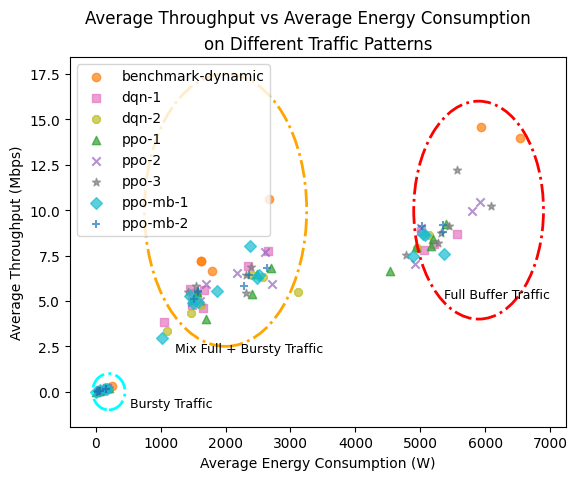

In [69]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, Circle

# colors = ['tab:orange', 'tab:pink' ,  'tab:blue', 'tab:purple', 'tab:green', "tab:cyan"]
# markers = ['o','s', '+', 'x', '^', 'D']

plt.figure()
# 
ax = plt.gca()
for idx, valid_sims in enumerate(all_valid_sims):
    avg_throughputs = []
    avg_en_cons = []
    for sim in valid_sims:
        data = extract_from_db(os.path.join(sim, "database.db"))
        avg_throughputs.append(np.mean(data[:, 1]))   # throughput
        avg_en_cons.append(np.mean(data[:, 2]))       # energy consumption
    plt.scatter(
        avg_en_cons, avg_throughputs,
        color=colors[idx],
        marker=markers[idx],
        label=metadata[idx],
        alpha=0.7
    )

ellipse_1 = Ellipse((5900, 10), width=2000, height=12, angle=0, color='red', fill=False, linewidth=2, linestyle='-.')
ellipse_2 = Ellipse((2000, 10), width=2500, height=15, angle=0, color='orange', fill=False, linewidth=2, linestyle='-.')
ellipse_3 = Ellipse((200, 0), width=500, height=2, angle=0, color='cyan', fill=False, linewidth=2, linestyle='-.')
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)
ax.add_patch(ellipse_3)

plt.text(7000, 5, f"Full Buffer Traffic", fontsize=9, ha='right', va='bottom')
plt.text(3500, 2, f"Mix Full + Bursty Traffic", fontsize=9, ha='right', va='bottom')
plt.text(1800, -1, f"Bursty Traffic", fontsize=9, ha='right', va='bottom')

plt.xlabel("Average Energy Consumption (W)")
plt.ylabel("Average Throughput (Mbps)")
plt.suptitle("Average Throughput vs Average Energy Consumption ")
plt.title("on Different Traffic Patterns")
plt.legend()
plt.show()

## Scatter Plot (Aggregated)

In [70]:
from collections import defaultdict

# Define energy consumption bins
def get_traffic_group(en_cons):
    if en_cons < 500:
        return "Bursty"
    elif en_cons <= 3500:
        return "Mix"
    else:
        return "Full"

group_names = ["Bursty", "Mix", "Full"]

# For each simulation type, collect group averages
all_group_averages = defaultdict(lambda: {
    g: {"throughput": [], "en_cons": [], "rlf": [], "on_cost": []} 
    for g in group_names}
)

for idx, valid_sims in enumerate(all_valid_sims):
    for sim in valid_sims:
        data = extract_from_db(os.path.join(sim, "database.db"))
        avg_en_cons = np.mean(data[:, 2])
        avg_throughput = np.mean(data[:, 1])
        avg_rlf = np.mean(data[:, 3])
        avg_on_cost = np.mean(data[:, 4])
        group = get_traffic_group(avg_en_cons)
        all_group_averages[idx][group]["throughput"].append(avg_throughput)
        all_group_averages[idx][group]["en_cons"].append(avg_en_cons)
        all_group_averages[idx][group]["rlf"].append(avg_rlf)
        all_group_averages[idx][group]["on_cost"].append(avg_on_cost)

# Compute mean for each group per simulation type
group_avg_throughputs = []
group_avg_en_cons = []
group_avg_rlf = []
group_avg_on_cost = []

for idx in range(len(metadata)):
    sim_group_thr = []
    sim_group_en = []
    sim_group_rlf = []
    sim_group_on_cost = []
    for group in group_names:
        thr = all_group_averages[idx][group]["throughput"]
        en = all_group_averages[idx][group]["en_cons"]
        rlf = all_group_averages[idx][group]["rlf"]
        on_cost = all_group_averages[idx][group]["on_cost"]
        if thr and en:
            sim_group_thr.append(np.mean(thr))
            sim_group_en.append(np.mean(en))
            sim_group_rlf.append(np.mean(rlf))
            sim_group_on_cost.append(np.mean(on_cost))
        else:
            sim_group_thr.append(np.nan)
            sim_group_en.append(np.nan)
            sim_group_rlf.append(np.nan)
            sim_group_on_cost.append(np.nan)
    group_avg_throughputs.append(sim_group_thr)
    group_avg_en_cons.append(sim_group_en)
    group_avg_rlf.append(sim_group_rlf)
    group_avg_on_cost.append(sim_group_on_cost)

In [71]:
import pandas as pd

group_avg_throughputs_df = pd.DataFrame(
    group_avg_throughputs,
    index=metadata,
    columns=group_names
)
group_avg_throughputs_df

,Bursty,Mix,Full
benchmark-dynamic,0.224947,7.930888,14.257665
dqn-1,0.130666,5.573692,8.377660
dqn-2,0.107583,5.129489,8.266068
ppo-1,0.105332,5.540193,8.055599
ppo-2,0.134791,6.014179,9.112232
ppo-3,0.124409,6.005462,9.334886
ppo-mb-1,0.099840,5.546865,8.112176
ppo-mb-2,0.080251,5.865728,9.034070


In [72]:
import pandas as pd

group_avg_en_cons_df = pd.DataFrame(
    group_avg_en_cons,
    index=metadata,
    columns=group_names
)
group_avg_en_cons_df

,Bursty,Mix,Full
benchmark-dynamic,190.368625,1930.074495,6243.777778
dqn-1,118.046974,1723.367002,5210.752288
dqn-2,97.399854,1978.674061,5037.694205
ppo-1,100.018618,2058.309990,5046.264926
ppo-2,125.596886,2049.689793,5410.065723
ppo-3,120.796844,1994.737911,5413.992332
ppo-mb-1,96.164045,1847.368843,5093.538687
ppo-mb-2,76.060968,1993.082201,5245.268788


In [73]:
import pandas as pd

group_avg_rlf_df = pd.DataFrame(
    group_avg_rlf,
    index=metadata,
    columns=group_names
)
group_avg_rlf_df

,Bursty,Mix,Full
benchmark-dynamic,1.441057,1.338384,1.065657
dqn-1,2.515038,2.639852,1.985329
dqn-2,1.975000,3.831154,2.072265
ppo-1,3.774996,2.626079,2.576939
ppo-2,2.522491,2.513139,2.338264
ppo-3,2.429861,3.147866,2.219001
ppo-mb-1,1.960122,3.188614,2.362314
ppo-mb-2,2.333794,2.638231,2.012993


In [74]:
import pandas as pd

group_avg_on_cost_df = pd.DataFrame(
    group_avg_on_cost,
    index=metadata,
    columns=group_names
)
group_avg_on_cost_df

,Bursty,Mix,Full
benchmark-dynamic,0.342061,0.320707,0.343535
dqn-1,2.802188,2.541906,2.661499
dqn-2,2.647659,2.917829,2.806398
ppo-1,2.208010,2.801448,2.736064
ppo-2,1.802059,1.834240,1.742001
ppo-3,2.001092,1.872116,1.778552
ppo-mb-1,2.085841,2.754421,2.750869
ppo-mb-2,2.436083,2.898579,2.697764


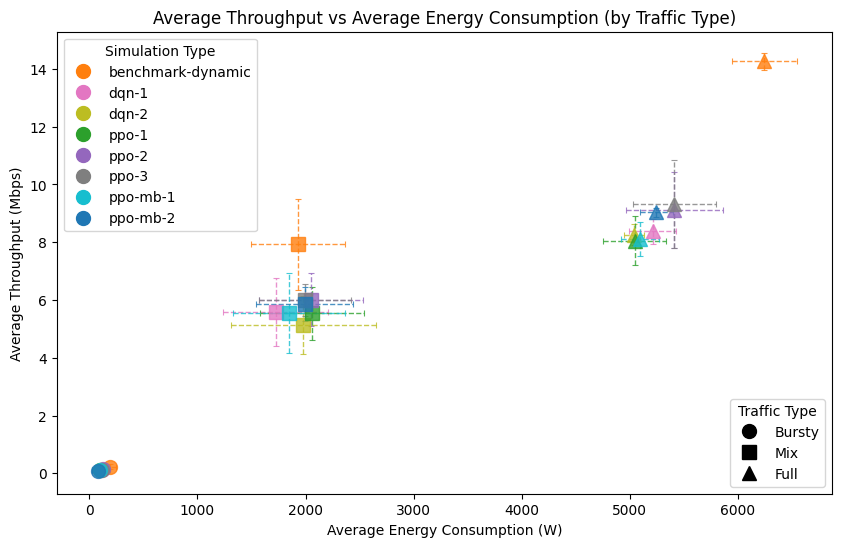

In [75]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

plt.figure(figsize=(10, 6))
g_markers = ['o', 's', '^']

sim_handles = []
group_handles = []

for idx, sim_name in enumerate(metadata):
    for gidx, group in enumerate(group_names):
        # Get all values for this group and simulation
        thr_values = all_group_averages[idx][group]["throughput"]
        en_values = all_group_averages[idx][group]["en_cons"]
        if thr_values and en_values:
            avg_en = np.mean(en_values)
            avg_thr = np.mean(thr_values)
            std_en = np.std(en_values)
            std_thr = np.std(thr_values)
            # Only add one handle per simulation type for legend
            if gidx == 0:
                sim_handles.append(
                    Line2D([0], [0], marker='o', color=colors[idx], label=sim_name, linestyle='', markersize=10)
                )
            # Scatter with error bars
            err = plt.errorbar(
                avg_en, avg_thr,
                xerr=std_en, yerr=std_thr,
                fmt=g_markers[gidx],
                color=colors[idx],
                label=None,
                markersize=10,
                capsize=2,                # shorter tick
                elinewidth=1,             # thinner line
                alpha=0.8,
                capthick=0.8              # thinner cap
            )
            for bar in err[2]:
                bar.set_linestyle('dashed')

group_handles = [
    Line2D([0], [0], marker=m, color='k', linestyle='', label=group, markersize=10)
    for m, group in zip(g_markers, group_names)
]

plt.xlabel("Average Energy Consumption (W)")
plt.ylabel("Average Throughput (Mbps)")
plt.title("Average Throughput vs Average Energy Consumption (by Traffic Type)")

first_legend = plt.legend(handles=sim_handles, title="Simulation Type", loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=group_handles, title="Traffic Type", loc='lower right')

plt.show()

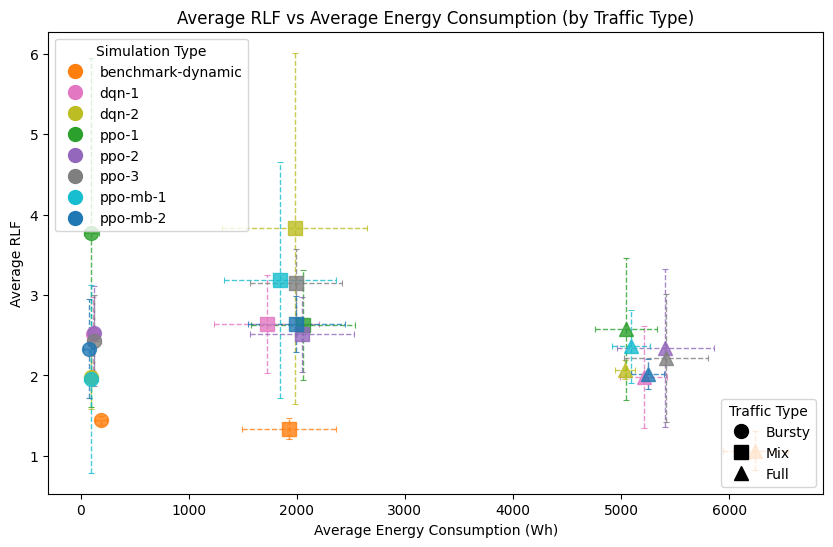

In [76]:
# RLF vs Energy Consumption
plt.figure(figsize=(10, 6))
sim_handles = []
group_handles = []
for idx, sim_name in enumerate(metadata):
    for gidx, group in enumerate(group_names):
        rlf_values = all_group_averages[idx][group]["rlf"]
        en_values = all_group_averages[idx][group]["en_cons"]
        if rlf_values and en_values:
            avg_en = np.mean(en_values)
            avg_rlf = np.mean(rlf_values)
            std_en = np.std(en_values)
            std_rlf = np.std(rlf_values)
            if gidx == 0:
                sim_handles.append(
                    Line2D([0], [0], marker='o', color=colors[idx], label=sim_name, linestyle='', markersize=10)
                )
            err = plt.errorbar(
                avg_en, avg_rlf,
                xerr=std_en, yerr=std_rlf,
                fmt=g_markers[gidx],
                color=colors[idx],
                label=None,
                markersize=10,
                capsize=2,
                elinewidth=1,
                alpha=0.8,
                capthick=0.8
            )
            for bar in err[2]:
                bar.set_linestyle('dashed')

group_handles = [
    Line2D([0], [0], marker=m, color='k', linestyle='', label=group, markersize=10)
    for m, group in zip(g_markers, group_names)
]
plt.xlabel("Average Energy Consumption (Wh)")
plt.ylabel("Average RLF")
plt.title("Average RLF vs Average Energy Consumption (by Traffic Type)")
first_legend = plt.legend(handles=sim_handles, title="Simulation Type", loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=group_handles, title="Traffic Type", loc='lower right')
plt.show()

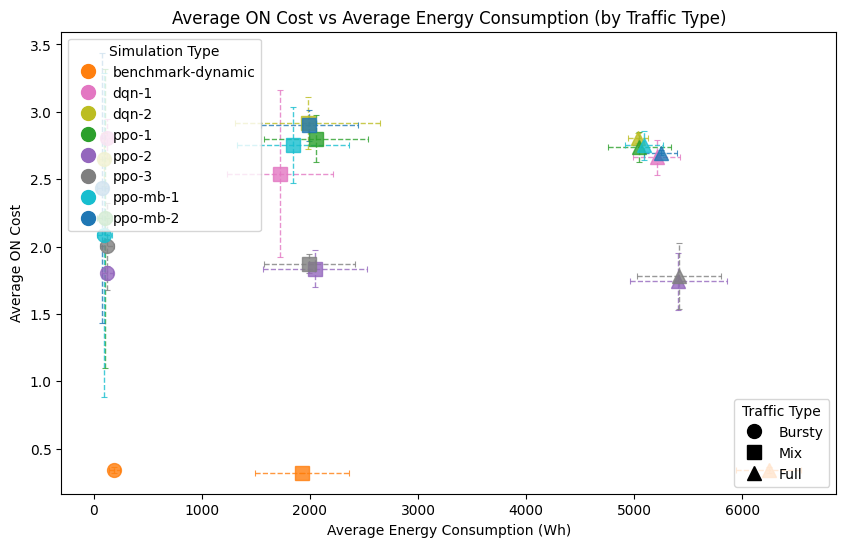

In [77]:
# ON Cost vs Energy Consumption
plt.figure(figsize=(10, 6))
sim_handles = []
group_handles = []
for idx, sim_name in enumerate(metadata):
    for gidx, group in enumerate(group_names):
        on_cost_values = all_group_averages[idx][group]["on_cost"]
        en_values = all_group_averages[idx][group]["en_cons"]
        if on_cost_values and en_values:
            avg_en = np.mean(en_values)
            avg_on_cost = np.mean(on_cost_values)
            std_en = np.std(en_values)
            std_on_cost = np.std(on_cost_values)
            if gidx == 0:
                sim_handles.append(
                    Line2D([0], [0], marker='o', color=colors[idx], label=sim_name, linestyle='', markersize=10)
                )
            err = plt.errorbar(
                avg_en, avg_on_cost,
                xerr=std_en, yerr=std_on_cost,
                fmt=g_markers[gidx],
                color=colors[idx],
                label=None,
                markersize=10,
                capsize=2,
                elinewidth=1,
                alpha=0.8,
                capthick=0.8
            )
            for bar in err[2]:
                bar.set_linestyle('dashed')

group_handles = [
    Line2D([0], [0], marker=m, color='k', linestyle='', label=group, markersize=10)
    for m, group in zip(g_markers, group_names)
]
plt.xlabel("Average Energy Consumption (Wh)")
plt.ylabel("Average ON Cost")
plt.title("Average ON Cost vs Average Energy Consumption (by Traffic Type)")
first_legend = plt.legend(handles=sim_handles, title="Simulation Type", loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=group_handles, title="Traffic Type", loc='lower right')
plt.show()